<center>

# Flight Delay Predict

#### Data Science Bootcamp Capstone Project
#### Elia Abu-Manneh
##### April 11 2023

</center

## Part 3: Neural Network Modelling

In [304]:
# Imports

import os
import pandas as pd
import numpy as np
from skimage.io import imread
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras import datasets, layers, models
from IPython.display import clear_output
import matplotlib.pyplot as plt

np.random.seed(0)

%matplotlib inline
import seaborn as sns
import PIL
from PIL import Image

## Make the 5-10 boxes below into a function !!! def model_import(airport_id):

In [354]:
ontime_10423 = pd.read_csv('../processed_data/ontime_10423.csv')

In [355]:
#y1 = ontime_10423.iloc[:,-64:]
y1 = ontime_10423['DEP_DELAY']
y1.fillna(0, inplace=True)

y2 = ontime_10423['CANCELLED']

X_data = ontime_10423.iloc[:,:-64]
X_data.drop(['ORIGIN_AIRPORT_ID','DEP_DELAY','CANCELLED'], axis=1, inplace=True)

In [356]:
X_data.shape

(244019, 43)

In [357]:
X_data.head(4)

,YTD,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_EV,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_G4,OP_UNIQUE_CARRIER_HA,...,DEST_AIRPORT_ID_11042,DEST_AIRPORT_ID_11057,DEST_AIRPORT_ID_11066,DEST_AIRPORT_ID_11193,DEST_AIRPORT_ID_11259,DEST_AIRPORT_ID_11278,DEST_AIRPORT_ID_11292,DEST_AIRPORT_ID_11298,DEST_AIRPORT_ID_11423,DEST_AIRPORT_ID_11433
0,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [360]:
y1

0          16.0
1           0.0
2           0.0
3           0.0
4           1.0
          ...  
244014      0.0
244015      0.0
244016      0.0
244017    291.0
244018      0.0
Name: DEP_DELAY, Length: 244019, dtype: float64

In [361]:
y1 = y1.clip(upper=200) #Clipping Any data above 200 will equal 200
                        #Clipping is not advisable, the model is not well structured
y1

0          16.0
1           0.0
2           0.0
3           0.0
4           1.0
          ...  
244014      0.0
244015      0.0
244016      0.0
244017    200.0
244018      0.0
Name: DEP_DELAY, Length: 244019, dtype: float64

In [363]:
# Scale numerical features 
def ytd_scaler(df):
    numerical_cols = ['YTD']
    scaler = MinMaxScaler()
    dfnum = scaler.fit_transform(df[numerical_cols])
    return dfnum

In [364]:
X_num = ytd_scaler(X_data)

In [365]:
X_data.drop(['YTD'], axis=1, inplace=True)

In [366]:
# Combine encoded categorical and scaled numerical features
X = np.concatenate((X_data, X_num), axis=1)

In [367]:
(X[1]).shape

(43,)

In [368]:
print(X[0])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.00274725]


In [370]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42) #random_state original 42

In [371]:
#Define model
with tf.device('/device:GPU:0'):
    model = keras.Sequential()

    model.add(Dense(128, input_dim=43, activation='relu'))

    model.add(Dropout(0.25)) 

    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.25)) 

    model.add(Dense(32, activation='relu'))
      
    model.add(Dense(1, activation='linear'))

    model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               5632      
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 33        
Total params: 16,001
Trainable params: 16,001
Non-trainable params: 0
_________________________________________________

In [372]:
X_train.shape[1]

43

In [373]:
import tensorflow.keras.backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [375]:
# Compile model
#model.compile(loss=CategoricalCrossentropy,optimizer='adam', metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    model.compile(
        optimizer='adam',  # using the Adam optimizer
        loss='mean_squared_error',  # using mean squared error as the loss function
        metrics=[rmse]  # using mean squared error as the evaluation metric
    )

In [376]:
# Train the model and store the history
with tf.device('/device:GPU:0'):
    history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/3
6101/6101 [==============================] - 25s 4ms/step - loss: 1057.7675 - rmse: 30.3179 - val_loss: 1038.9507 - val_rmse: 29.9924
Epoch 2/3
6101/6101 [==============================] - 27s 4ms/step - loss: 1056.1663 - rmse: 30.2745 - val_loss: 1039.7876 - val_rmse: 30.1004
Epoch 3/3
6101/6101 [==============================] - 26s 4ms/step - loss: 1055.0262 - rmse: 30.1843 - val_loss: 1038.1742 - val_rmse: 29.9286


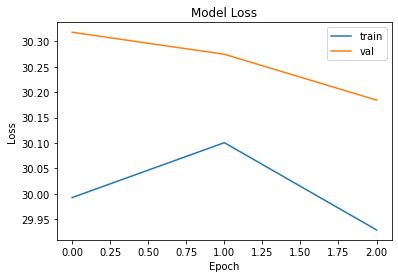

In [377]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['val_rmse'])
plt.plot(history.history['rmse'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [379]:
# Prepare new data for prediction

new_data = X[1].reshape(-1,43)  #sample input
#type(X[1]) is an numpy.ndarray


# Make prediction with the model
prediction = model.predict(new_data)
print(prediction)

[[6.9403734]]


In [380]:
#Correct Answer 
y1[1]

0.0

Lookup: 
* How to deal with skewed data
* Look at how to deal with non-normally distributed data
* More specifically for Neural networks

* Try changing the neural network

Use Absolute Error to assess final accuracy

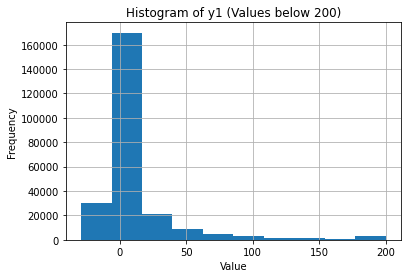

In [362]:
y1_filtered = y1  # Filter values below 500
y1_filtered.hist()
plt.title('Histogram of y1 (Values below 200)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [134]:
y2

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
244014    1.0
244015    1.0
244016    1.0
244017    0.0
244018    1.0
Name: CANCELLED, Length: 244019, dtype: float64

1. Try processing data, modelling for only one airport (eg; Austin) -- DONE --
2. Try different buckets of delay (-, 0 , 0-15, 15-30)  
3. Try to scale on multiple 
4. Breakup the notebooks to multiple notebooks -- DONE --
5. Insure markdowns, notes are cohesive and clear -- DONE --